In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
import os
os.chdir("/content/gdrive/MyDrive/Usc/EE641/Project/")
print("current working directory is ", os.getcwd())

current working directory is  /content/gdrive/.shortcut-targets-by-id/1UxC4FxhE8TlVbo2V3frIK8m5zLDVpRPc/Project


In [3]:
!pip install yacs
!pip install thop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import seg_models as sm
from thop import profile
import torch.nn as nn
import h5py
import numpy as np
from utils import *
device = (torch.device('cuda') if torch.cuda.is_available()
                  else torch.device('cpu'))

# Compare Flops

In [ ]:
encoder_name = ["resnet18", "resnet34", "resnet50", "resnet101", "resnet152", "mobilenet_v2",
              "micronet_m0", "micronet_m1", "micronet_m2", "micronet_m3"]
print("%s & %s & %s" % ("Encoder", "Params(M)", "FLOPs(G)"))
for name in encoder_name:
    model = sm.Unet(
        encoder_name=name,
        in_channels=1,                  
        classes=1,
        decoder_channels = (256, 128, 64, 32, 16),
        activation=torch.nn.Sigmoid                      
    ).to(device)

    inputs = torch.randn(1, 1, 256, 256).to(device)
    total_ops, total_params = profile(model, (inputs,), verbose=False)
    total_params /= (1000 ** 2)
    total_ops /= (1000 ** 3)
    print(f"{name:12} & {total_params:.2f} & {total_ops:.2f}")

Encoder & Params(M) & FLOPs(G)
resnet18     & 14.32 & 5.32
resnet34     & 24.43 & 7.75
resnet50     & 32.51 & 10.60
resnet101    & 51.51 & 15.48
resnet152    & 67.15 & 20.36
mobilenet_v2 & 6.63 & 3.39
micronet_m0  & 2.29 & 2.29
micronet_m1  & 2.86 & 2.42
micronet_m2  & 3.71 & 2.59
micronet_m3  & 4.10 & 2.70


# Compare infection segmentation results

In [ ]:
path = "HDF5Data/infect_data.hdf5"
test_img_transforms = transforms.Compose([transforms.Normalize((0.5302),(0.2452))])
test_dataset = HDF5Dataset(path, 'test', img_transform=test_img_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=2)

In [ ]:
name_list = ['resnet18', 'mobilenet_v2']
name_list.extend([f'micronet_m{i}' for i in range(4)])
dict_name = {'resnet18':'ResNet18','mobilenet_v2':'MobileNet V2','micronet_m0':'MicroNet M0',
             'micronet_m1':'MicroNet M1','micronet_m2':'MicroNet M2','micronet_m3':'MicroNet M3'}
print("Encoder & Accuracy & IoU & DSC")
for encoder_name in name_list:
    model = torch.load(f'trained_models/infect_Unet_{encoder_name}.pt', 
                        map_location=device)
    
    test_loop(model, dict_name[encoder_name], test_loader, 
              mask_name='infection mask', device=device)

Encoder & Accuracy & IoU & DSC
ResNet18 & 98.0 ± 3.12 & 83.1 ± 24.39 & 88.12 ± 20.26
MobileNet V2 & 98.04 ± 2.94 & 83.65 ± 23.73 & 88.62 ± 19.58
MicroNet M0 & 97.74 ± 3.4 & 81.54 ± 25.59 & 86.87 ± 21.43
MicroNet M1 & 97.73 ± 3.5 & 80.79 ± 26.3 & 86.18 ± 22.28
MicroNet M2 & 97.81 ± 3.39 & 81.87 ± 25.35 & 87.17 ± 20.92
MicroNet M3 & 97.92 ± 3.21 & 82.73 ± 24.27 & 87.98 ± 19.56


# Compare lung segmentation results

In [ ]:
path = "HDF5Data/lung_data.hdf5"
test_img_transforms = transforms.Compose([transforms.Normalize((0.5127),(0.2474))])
test_dataset = HDF5Dataset(path, 'test', img_transform=test_img_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=2)

In [ ]:
name_list = ['resnet18', 'mobilenet_v2']
name_list.extend([f'micronet_m{i}' for i in range(4)])
dict_name = {'resnet18':'ResNet18','mobilenet_v2':'MobileNet V2','micronet_m0':'MicroNet M0',
             'micronet_m1':'MicroNet M1','micronet_m2':'MicroNet M2','micronet_m3':'MicroNet M3'}
print("Encoder & Accuracy & IoU & DSC")
for encoder_name in name_list:
    model = torch.load(f'trained_models/lung_Unet_{encoder_name}.pt', 
                        map_location=device)
    
    test_loop(model, dict_name[encoder_name], test_loader, 
              mask_name='lung mask', device=device)

Encoder & Accuracy & IoU & DSC
ResNet18 & 99.03 ± 0.77 & 95.75 ± 3.33 & 97.8 ± 1.83
MobileNet V2 & 99.01 ± 0.78 & 95.67 ± 3.31 & 97.76 ± 1.82
MicroNet M0 & 98.91 ± 0.86 & 95.21 ± 3.71 & 97.51 ± 2.06
MicroNet M1 & 98.89 ± 0.84 & 95.12 ± 3.7 & 97.46 ± 2.06
MicroNet M2 & 98.92 ± 0.84 & 95.25 ± 3.69 & 97.53 ± 2.05
MicroNet M3 & 98.95 ± 0.81 & 95.35 ± 3.55 & 97.59 ± 1.96


# Compare COVID19 detection result

In [ ]:
path = "HDF5Data/infect_data.hdf5"
test_img_transforms = transforms.Compose([transforms.Normalize((0.5302),(0.2452))])
test_dataset = HDF5Dataset(path, 'test', img_transform=test_img_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=2)

In [ ]:
name_list = ['resnet18', 'mobilenet_v2']
name_list.extend([f'micronet_m{i}' for i in range(4)])
dict_name = {'resnet18':'ResNet18','mobilenet_v2':'MobileNet V2','micronet_m0':'MicroNet M0',
             'micronet_m1':'MicroNet M1','micronet_m2':'MicroNet M2','micronet_m3':'MicroNet M3'}
print("Encoder & Accuracy & Sensitivity & Specificity & Precision & F1-score")
for encoder_name in name_list:
    model = torch.load(f'trained_models/infect_Unet_{encoder_name}.pt', 
                        map_location=device)
    
    COVID_detection(model, dict_name[encoder_name], test_loader, device=device)

Encoder & Accuracy & Sensitivity & Specificity & Precision & F1-score
ResNet18 & 98.63 & 98.46 & 98.8 & 98.8 & 98.63
MobileNet V2 & 99.06 & 99.49 & 98.63 & 98.64 & 99.06
MicroNet M0 & 98.63 & 98.46 & 98.8 & 98.8 & 98.63
MicroNet M1 & 98.37 & 99.31 & 97.43 & 97.47 & 98.39
MicroNet M2 & 99.23 & 98.97 & 99.49 & 99.48 & 99.23
MicroNet M3 & 99.31 & 98.97 & 99.66 & 99.65 & 99.31


# Plot the comparison

In [5]:
path = "HDF5Data/infect_data.hdf5"
with h5py.File(path, 'r') as hf:
    test_data = hf['test'][:]
data = test_data[97]

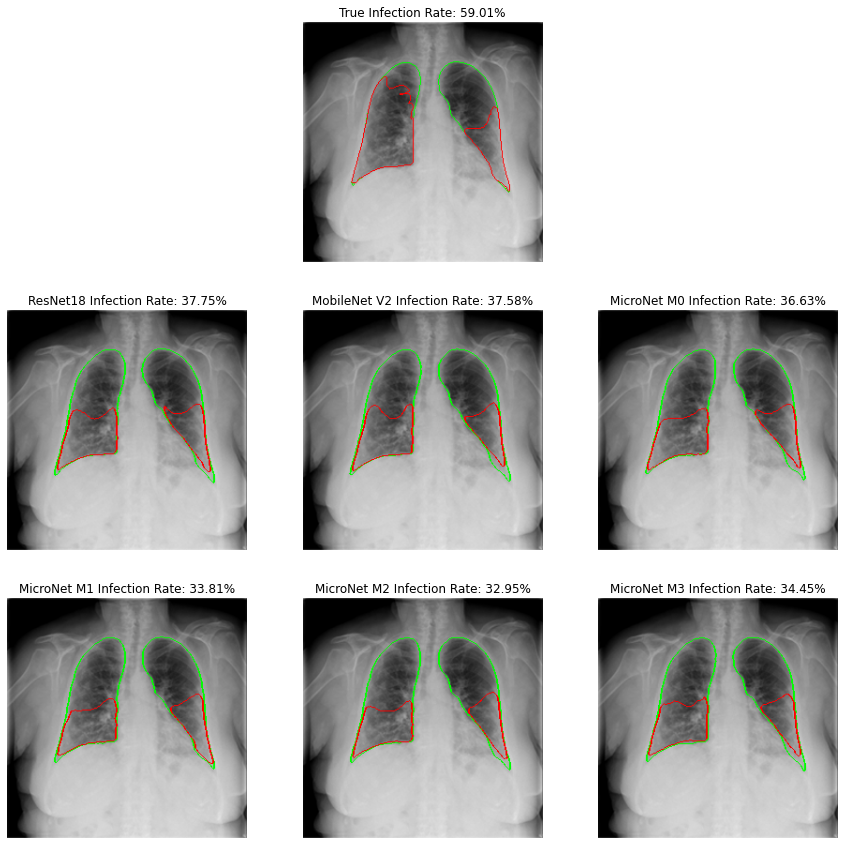

In [6]:
plot_one_image(data, device=device)